In [1]:
import os
import ast
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.family'] = 'DejaVu Serif'

# parsing experiment logs

In [3]:
def process_log(input_path):
    # each element in output is 
    output = []
    curr_lst = []
    heuristic = ''
    with open(input_path, 'r') as input_file:
        # Process each line in the input file
        for line in input_file:
            if line.strip().startswith("heuristic"):
                heuristic = line.split('heuristic')[1].strip()
            elif line.strip().startswith("running experiments:"):
                if curr_lst:
                    if heuristic:
                        curr_lst.append(heuristic)
                        heuristic = ''
                        
                    output.append(curr_lst)
                    curr_lst = []
                stringified_list = line.split('running experiments:')[-1].strip()
                curr_lst.append(ast.literal_eval(stringified_list))
            elif line.strip().startswith("starter:"):
                curr_lst.append(line.split('starter:')[-1].strip())
            elif line.strip().startswith("saved to folder:"):
                curr_lst.append(line.split('saved to folder:')[-1].strip())

    # add leftover lst
    if curr_lst:
        output.append(curr_lst)
        
    return output

In [4]:
def process_results(fp):
    results = process_log(input_path=fp)
    output_dict = {}
    
    for lst in results:
        if len(lst) == 3:
            exps, starter_file, logs = lst
            heuristic = None
        else:
            exps, starter_file, logs, heuristic = lst

        folder_path = os.path.join(logs, "exp_results")
        json_data_list = []

        # Iterate over each file in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
        
            # Check if the file is a JSON file
            if filename.endswith(".json"):
                # Open and read the JSON file
                with open(file_path, 'r') as file:
                    # Load JSON content and add it to the list
                    json_data = json.load(file)                    
                    json_data_list.append(json_data)

        log_file_name = logs.split('/')[1]
        output_dict[log_file_name] = {
            'exps': exps,
            'starter': starter_file.split('/')[1].split('.json')[0],
            'data': json_data_list,
        }
        if heuristic:
            output_dict[log_file_name]['heuristic'] = heuristic
    return output_dict

`output.log` tried (for each starter file) 
- all 10 exps in order [1 * 2]
- the same exp 10 times [10 * 2]

In [5]:
output_1 = process_results(fp='output_logs/output.log')

In [6]:
def get_starter_type(dict, starter='standard'):
    output = {}
    for key, val in dict.items():
        if val['starter'] == starter:
            output[key] = val
    return output

In [7]:
VIOLATIONS = ["offtrack", "overspeed", "underspeed", "uncomfortable", "wronglane", "collision"]

In [8]:
def process_output_1_avgs(starter):
    dict = get_starter_type(output_1, starter)
    
    output = {}
    for _, val in dict.items():
        exps, data = val['exps'], val['data']

        # exp name is either all the exps or just one for output_1
        exp_name = 'all'
        if all(elem == exps[0] for elem in exps):
            exp_name = exps[0]

        output[exp_name] = {}

        metrics = VIOLATIONS + ['cost']
        
        for d in data:
            for d_key, d_val in d.items():
                if d_key in metrics:
                    if d_key in output[exp_name]:
                        output[exp_name][d_key] += d_val
                    else:
                        output[exp_name][d_key] = d_val

        # compute averages
        for key, val in output[exp_name].items():
            output[exp_name][key] = val / len(data)
    return output

In [9]:
def process_output_1(starter):
    dict = get_starter_type(output_1, starter)
    
    output = {}
    for _, val in dict.items():
        exps, data = val['exps'], val['data']

        # exp name is either all the exps or just one for output_1
        exp_name = 'all'
        if all(elem == exps[0] for elem in exps):
            exp_name = exps[0]

        output[exp_name] = {}

        metrics = VIOLATIONS + ['cost']
        
        for d in data:
            for d_key, d_val in d.items():
                if d_key in metrics:
                    if d_key in output[exp_name]:
                        output[exp_name][d_key] += [d_val]
                    else:
                        output[exp_name][d_key] = [d_val]
                        
    return output

# plotting

## naive orderings

In [10]:
# copying over parsed costs for individual weeks from log files
# NOTE this is for standard initialization only
def fix_output_1(output_1_dict):
    costs_week8_01 = [
        -144.93527598419502,
        224.34499698826286,
        116.12806308486472,
        114.19170176331008,
        113.75763747585201,
        111.81679647749102,
        111.099586652205,
        110.72436829533956,
        110.69920646259497,
        110.66202542118783
    ]
    
    costs_week8_02 = [
        -147.14265248638534,
        151.47551113423,
        44.81453141997934,
        44.71891107923895,
        44.539575524689184,
        44.442697330941975,
        44.26164736699792,
        45.82389099468218,
        43.485075589452656,
        43.485077962848415
    ]
    
    costs_week8_03 = [
        -147.14265248638534,
        151.47551113423,
        44.81453141997934,
        44.71891107923895,
        44.539575524689184,
        44.442697330941975,
        44.26164736699792,
        45.82389099468218,
        43.485075589452656,
        43.485077962848415
    ]
    
    costs_week8_04 = [
        -143.39257096730972,
        163.33899431968433,
        44.76162485863175,
        44.5912149343812,
        44.43419312149142,
        44.34138023692007,
        44.11704783468701,
        45.035905813970714,
        43.508461506501206,
        43.48615065120064
    ]
    
    costs_week9_01 = [
        -149.52795618064133,
        188.42850958943606,
        106.74046632245059,
        106.74046659206059,
        106.74046658845357,
        106.74046662369756,
        106.74046662322604,
        106.74046656492227,
        106.74046656570228,
        106.74046660627695
    ]
    
    costs_week9_02 = [
        -149.55338447056792,
        188.49915540146387,
        106.74046267305842,
        106.74046602075671,
        106.7404659953743,
        106.74046274460092,
        106.7404627692519,
        106.74047892070934,
        106.74047879574856,
        106.74046270403971
    ]
    
    costs_week9_03 = [
        -146.92316043592524,
        238.79250857780167,
        109.90463617377452,
        109.90463487603428,
        109.90463488872379,
        109.90463488864313,
        109.90463488864393,
        109.90463488864387,
        109.9046348886439,
        109.9046348886439
    ]
    
    costs_week9_04 = [
        -145.91106445494466,
        175.49038032470008,
        91.43320936046672,
        89.53113825124163,
        88.76558112766563,
        88.76388768118115,
        88.76395575086919,
        88.76395514249187,
        88.76395442193429,
        88.76395438690402
    ]
    
    costs_week10_01 = [
        -145.9068747722437,
        150.78844227878486,
        44.82516759758669,
        44.72845388134854,
        44.548636879827605,
        44.45200769713721,
        44.27085296311833,
        45.83837437089571,
        43.487565902215884,
        43.48756593662941
    ]
    
    costs_week10_02 = [
        -145.38542319874608,
        153.67062317635538,
        44.18787993102426,
        45.325145425434215,
        43.48817974700971,
        43.48817986669789,
        43.486616297747034,
        43.48661623702957,
        43.486616235926796,
        43.48661623592679
    ]
    
    output_1_dict['Week8_01']['cost'] = costs_week8_01
    output_1_dict['Week8_02']['cost'] = costs_week8_02
    output_1_dict['Week8_03']['cost'] = costs_week8_03
    output_1_dict['Week8_04']['cost'] = costs_week8_04
    
    output_1_dict['Week9_01']['cost'] = costs_week9_01
    output_1_dict['Week9_02']['cost'] = costs_week9_02
    output_1_dict['Week9_03']['cost'] = costs_week9_03
    output_1_dict['Week9_04']['cost'] = costs_week9_04
    output_1_dict['Week10_01']['cost'] = costs_week10_01
    output_1_dict['Week10_02']['cost'] = costs_week10_02

    return output_1_dict

In [11]:
output_1_dict_avgs = process_output_1_avgs('standard')

In [12]:
output_1_dict = process_output_1('standard')
output_1_dict = fix_output_1(output_1_dict)

In [13]:
WEEK_8_EXPS = ["Week8_01", "Week8_02", "Week8_03", "Week8_04"]
WEEK_9_EXPS = ["Week9_01", "Week9_02", "Week9_03", "Week9_04"]
WEEK_10_EXPS = ["Week10_01", "Week10_02"]

ALL_EXPS = WEEK_8_EXPS + WEEK_9_EXPS + WEEK_10_EXPS

In [14]:
def plot_output_1(data, key, y_axis, title):
    for exp_name in ALL_EXPS + ['all']:
        res = data[exp_name][key]
        plt.plot(range(1, len(res) + 1), res, label=exp_name.title())
    
    # Customize the plot
    plt.xlabel('Iteration')
    plt.ylabel(y_axis)
    plt.xticks(range(1, len(res) + 1), range(1, len(res) + 1))
    plt.legend()
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.savefig(f'graphs/{title}.pdf', format='pdf', bbox_inches='tight')
    plt.show()

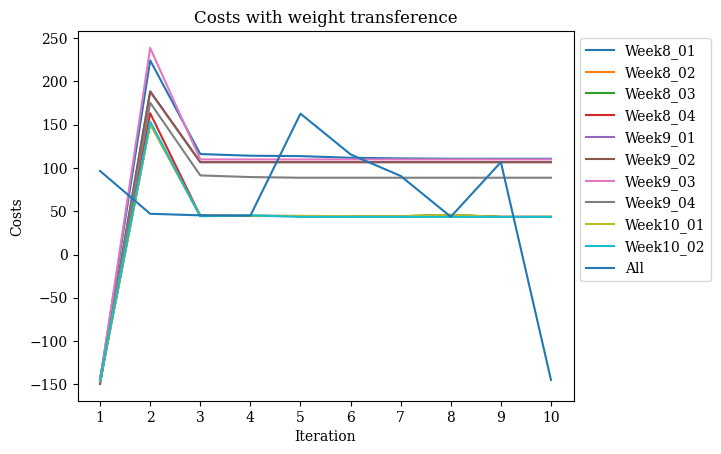

In [15]:
plot_output_1(output_1_dict, 'cost', 'Costs', 'Costs with weight transference')

In [16]:
pd.DataFrame({key: value['cost'] for key, value in output_1_dict.items()}).transpose()

,0,1,2,3,4,5,6,7,8,9
all,96.568349,47.106829,45.278198,44.930087,162.821817,115.738266,90.808863,43.604969,106.740463,-144.935276
Week8_01,-144.935276,224.344997,116.128063,114.191702,113.757637,111.816796,111.099587,110.724368,110.699206,110.662025
Week8_02,-147.142652,151.475511,44.814531,44.718911,44.539576,44.442697,44.261647,45.823891,43.485076,43.485078
Week8_03,-147.142652,151.475511,44.814531,44.718911,44.539576,44.442697,44.261647,45.823891,43.485076,43.485078
Week8_04,-143.392571,163.338994,44.761625,44.591215,44.434193,44.341380,44.117048,45.035906,43.508462,43.486151
Week9_01,-149.527956,188.428510,106.740466,106.740467,106.740467,106.740467,106.740467,106.740467,106.740467,106.740467
Week9_02,-149.553384,188.499155,106.740463,106.740466,106.740466,106.740463,106.740463,106.740479,106.740479,106.740463
Week9_03,-146.923160,238.792509,109.904636,109.904635,109.904635,109.904635,109.904635,109.904635,109.904635,109.904635
Week9_04,-145.911064,175.490380,91.433209,89.531138,88.765581,88.763888,88.763956,88.763955,88.763954,88.763954
Week10_01,-145.906875,150.788442,44.825168,44.728454,44.548637,44.452008,44.270853,45.838374,43.487566,43.487566


## category-specific

`output_2.log` tried (for each starter file) 
- just the same week 
- random shuffling

In [17]:
output_2 = process_results(fp='output_logs/output_2.log')

In [18]:
def process_output_2(starter):
    dict = get_starter_type(output_2, starter)
    
    output = {}
    for _, val in dict.items():
        exps, data = val['exps'], val['data']

        # exp name is either from same week or rnd for output 2
        exp_name = 'all'
        if len(exps) <= 4:
            exp_name = exps[0].split('_')[0]

        output[exp_name] = {}

        metrics = VIOLATIONS + ['cost']
        
        for d in data:
            for d_key, d_val in d.items():
                if d_key in metrics:
                    if d_key in output[exp_name]:
                        output[exp_name][d_key] += [d_val]
                    else:
                        output[exp_name][d_key] = [d_val]
    return output

In [19]:
def process_output_2_avgs(starter):
    dict = get_starter_type(output_2, starter)
    
    output = {}
    for _, val in dict.items():
        exps, data = val['exps'], val['data']

        # exp name is either from same week or rnd for output 2
        exp_name = 'all'
        if len(exps) <= 4:
            exp_name = exps[0].split('_')[0]

        output[exp_name] = {}

        metrics = VIOLATIONS + ['cost']
        
        for d in data:
            for d_key, d_val in d.items():
                if d_key in metrics:
                    if d_key in output[exp_name]:
                        output[exp_name][d_key] += d_val
                    else:
                        output[exp_name][d_key] = d_val

        # compute averages
        for key, val in output[exp_name].items():
            output[exp_name][key] = val / len(data)
    return output

In [20]:
output_2_dict = process_output_2('standard')

In [21]:
output_2_dict_avgs = process_output_2_avgs('standard')

In [22]:
def plot_output_2(data, key, y_axis, title):
    # Plotting for Week8
    week8_costs = data['Week8'][key]
    plt.plot(range(1, len(week8_costs) + 1), week8_costs, label='Week8')
    
    # Plotting for Week9
    week9_costs = data['Week9'][key]
    plt.plot(range(1, len(week9_costs) + 1), week9_costs, label='Week9')
    
    # Plotting for Week10
    week10_costs = data['Week10'][key]
    plt.plot(range(1, len(week10_costs) + 1), week10_costs, label='Week10')
    
    # Plotting for all
    all_costs = data['all'][key]
    plt.plot(range(1, len(all_costs) + 1), all_costs, label='Random shuffling')
    
    # Customize the plot
    plt.xlabel('Iteration')
    plt.ylabel(y_axis)
    plt.xticks(range(1, len(all_costs) + 1), range(1, len(all_costs) + 1))  # Set x-axis ticks and labels
    plt.legend()
    plt.title(title)

    plt.savefig(f'graphs/{title}.pdf', format='pdf')
    plt.show()

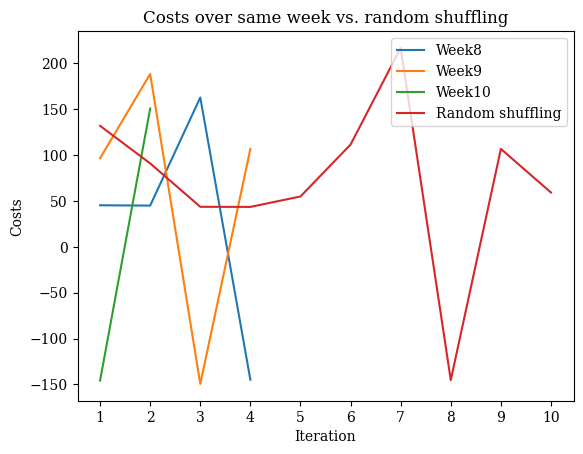

In [23]:
plot_output_2(output_2_dict, 'cost', 'Costs', 'Costs over same week vs. random shuffling')

In [24]:
max_length = max(len(value['cost']) for value in output_2_dict.values())
# fill w/ nan's
pd.DataFrame({key: value['cost'] + [np.nan] * (max_length - len(value['cost'])) for key, value in output_2_dict.items()}).T

,0,1,2,3,4,5,6,7,8,9
Week8,45.278198,44.930087,162.821817,-144.935276,NaN,NaN,NaN,NaN,NaN,NaN
Week9,96.568349,188.428226,-149.527956,106.740463,NaN,NaN,NaN,NaN,NaN,NaN
Week10,-145.906875,150.788442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
all,131.915565,90.947244,43.610565,43.512917,54.862808,111.500436,216.864321,-145.385423,106.750377,59.198563


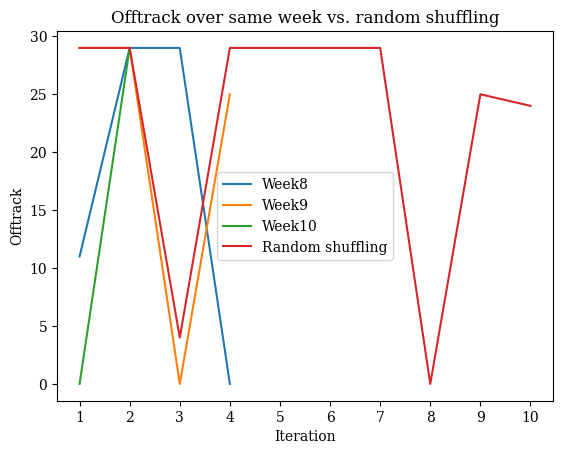

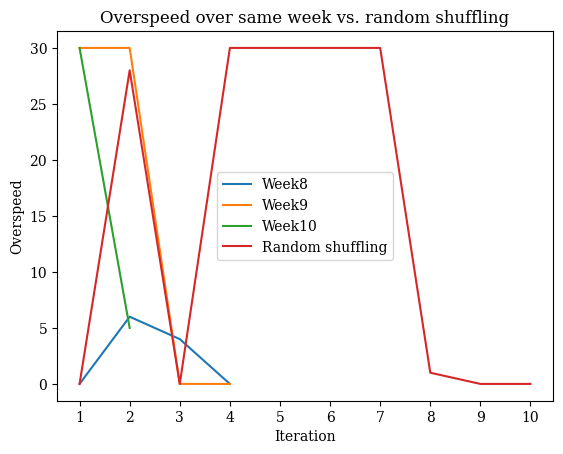

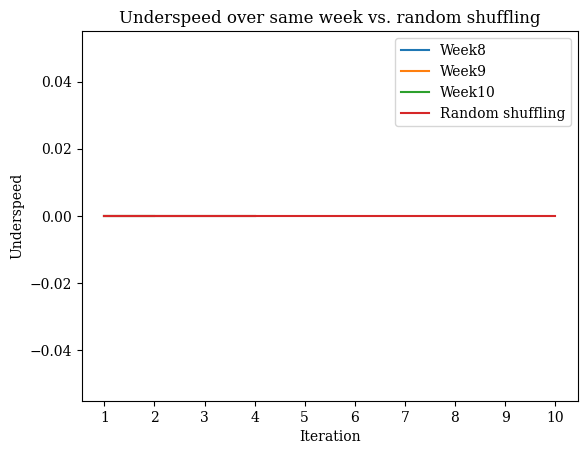

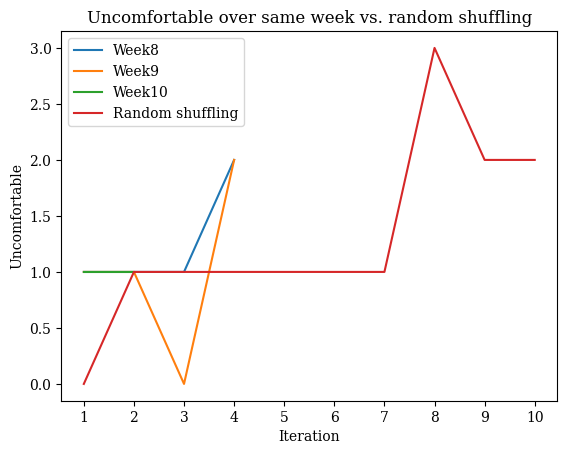

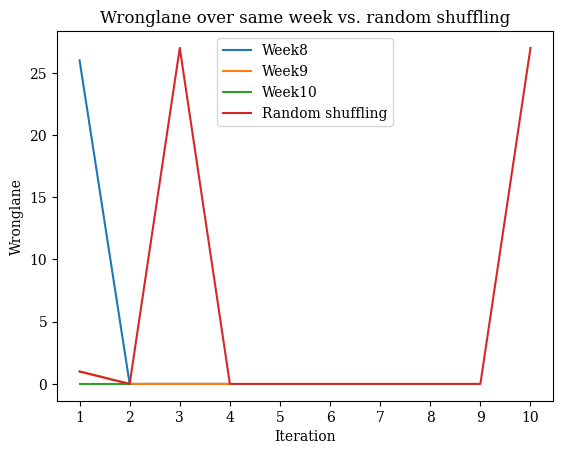

In [25]:
for viol in VIOLATIONS[:len(VIOLATIONS) - 1]: #ignore collisions bc week 9 doesn't have it
    plot_output_2(output_2_dict, viol, viol.title(), viol.title() + ' over same week vs. random shuffling')

## output 3

`output_3.log` tried 
- ordering all 10 by heuristic

In [26]:
output_3 = process_results(fp='output_logs/output_3.log')

In [27]:
def process_output_3(starter):
    dict = get_starter_type(output_3, starter)
    
    output = {}
    for key, val in dict.items():
        exps, data, heuristic = val['exps'], val['data'], val['heuristic']

        # exp name is always heuristic ordered
        exp_name = heuristic
        print(heuristic)

        output[exp_name] = {}

        metrics = VIOLATIONS + ['cost']
        
        for d in data:
            for d_key, d_val in d.items():
                if d_key in metrics:
                    if d_key in output[exp_name]:
                        output[exp_name][d_key] += [d_val]
                    else:
                        output[exp_name][d_key] = [d_val]

    return output

In [28]:
def process_output_3_avgs(starter):
    dict = get_starter_type(output_3, starter)
    
    output = {}
    for key, val in dict.items():
        exps, data, heuristic = val['exps'], val['data'], val['heuristic']

        # exp name is always heuristic ordered
        exp_name = heuristic

        output[exp_name] = {}

        metrics = VIOLATIONS + ['cost']
        
        for d in data:
            for d_key, d_val in d.items():
                if d_key in metrics:
                    if d_key in output[exp_name]:
                        output[exp_name][d_key] += d_val
                    else:
                        output[exp_name][d_key] = d_val

        # compute averages
        for key, val in output[exp_name].items():
            output[exp_name][key] = val / len(data)
    return output

In [29]:
output_3_dict = process_output_3('standard')

num_obstacles
num_vehicles
num_auto_vehicles


In [30]:
output_3_dict_avgs = process_output_3_avgs('standard')

In [31]:
def plot_output_3(data, key, y_axis, title):
    for exp_name in ['num_obstacles', 'num_vehicles', 'num_auto_vehicles']:
        res = data[exp_name][key]
        plt.plot(range(1, len(res) + 1), res, label=exp_name)
    
    # Customize the plot
    plt.xlabel('Iteration')
    plt.ylabel(y_axis)
    plt.xticks(range(1, len(res) + 1), range(1, len(res) + 1))
    plt.legend()
    plt.title(title)
    
    plt.savefig(f'graphs/{title}.pdf', format='pdf')
    plt.show()

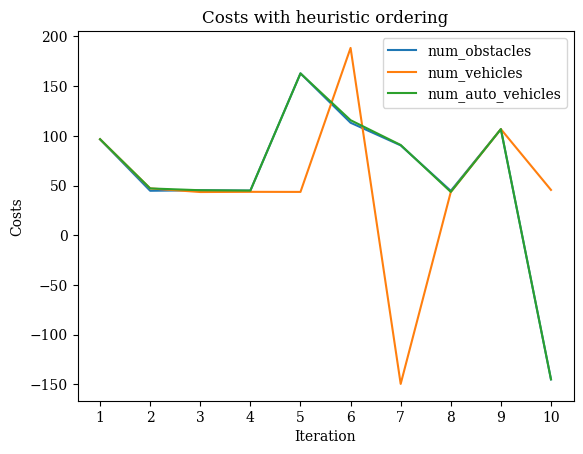

In [32]:
plot_output_3(output_3_dict, 'cost', 'Costs', 'Costs with heuristic ordering')

In [33]:
max_length = max(len(value['cost']) for value in output_3_dict.values())
# fill w/ nan's
pd.DataFrame({key: value['cost'] + [np.nan] * (max_length - len(value['cost'])) for key, value in output_3_dict.items()}).T

,0,1,2,3,4,5,6,7,8,9
num_obstacles,96.568349,44.743729,45.278198,44.930087,162.821817,113.169649,90.413951,44.658978,106.740463,-144.935276
num_vehicles,96.568349,47.106829,43.487700,43.673543,43.599196,188.428226,-149.527956,43.491866,106.740463,45.609541
num_auto_vehicles,96.568349,47.106829,45.278198,44.930087,162.821817,115.738266,90.808863,43.604969,106.740463,-144.935276


## llm-based intuition

llama suggestion based on heuristic ordering calculations in `output_3`, w/ data found in `output_6`

In [34]:
output_6 = process_results(fp='output_logs/output_6.log')

In [35]:
def process_output_6(starter):
    dict = get_starter_type(output_6, starter)
    
    output = {}
    data = dict[list(dict.keys())[0]]['data']
    exp_name = 'llama'

    output[exp_name] = {}

    metrics = VIOLATIONS + ['cost']
    
    for d in data:
        for d_key, d_val in d.items():
            if d_key in metrics:
                if d_key in output[exp_name]:
                    output[exp_name][d_key] += [d_val]
                else:
                    output[exp_name][d_key] = [d_val]

    return output

In [36]:
output_6_dict = process_output_6('standard')

In [37]:
def plot_output_6(data, comparison_data, key, y_axis, title):
    for exp_name in ['num_obstacles', 'num_vehicles', 'num_auto_vehicles']:
        res = comparison_data[exp_name][key]
        plt.plot(range(1, len(res) + 1), res, label=exp_name)
        
    for exp_name in ['llama']:
        res = data[exp_name][key]
        plt.plot(range(1, len(res) + 1), res, label=exp_name)
    
    # Customize the plot
    plt.xlabel('Iteration')
    plt.ylabel(y_axis)
    plt.xticks(range(1, len(res) + 1), range(1, len(res) + 1))
    plt.legend()
    plt.title(title)
    
    plt.savefig(f'graphs/{title}.pdf', format='pdf')
    plt.show()

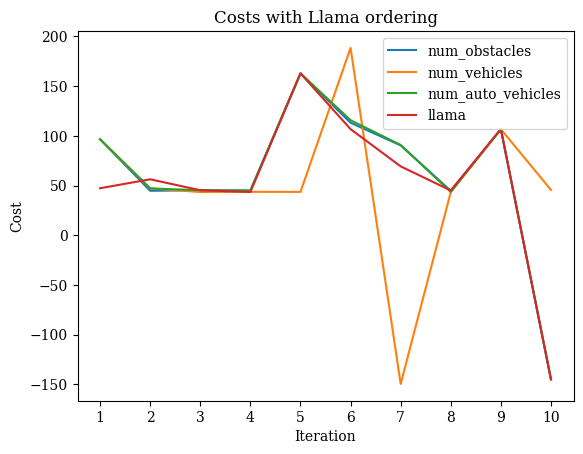

In [38]:
plot_output_6(output_6_dict, output_3_dict, 'cost', 'Cost', 'Costs with Llama ordering')

In [39]:
print("Average cost of llama's second proposed ordering is {:.2f}".format(np.mean(output_6_dict['llama']['cost'])))

Average cost of llama's second proposed ordering is 53.81


In [40]:
max_length = max(len(value['cost']) for value in output_6_dict.values())
# fill w/ nan's
df1 = pd.DataFrame({key: value['cost'] + [np.nan] * (max_length - len(value['cost'])) for key, value in output_6_dict.items()})
df2 = pd.DataFrame({key: value['cost'] + [np.nan] * (max_length - len(value['cost'])) for key, value in output_3_dict.items()})
df1.reset_index(inplace=True)
df2.reset_index(inplace=True)
merged = pd.merge(df1, df2, on='index', how='inner')
merged.drop(columns=['index'], inplace=True)
merged

,llama,num_obstacles,num_vehicles,num_auto_vehicles
0,47.283523,96.568349,96.568349,96.568349
1,56.282854,44.743729,47.106829,47.106829
2,45.278198,45.278198,43.487700,45.278198
3,43.506713,44.930087,43.673543,44.930087
4,162.821817,162.821817,43.599196,162.821817
5,106.740463,113.169649,188.428226,115.738266
6,69.284531,90.413951,-149.527956,90.808863
7,45.049684,44.658978,43.491866,43.604969
8,106.740494,106.740463,106.740463,106.740463
9,-144.935276,-144.935276,45.609541,-144.935276


## more plotting - specifically look at averages

In [41]:
def graph_avgs_across_runs(category):
    run_1 = list(output_1_dict_avgs.keys())
    run_1 = ['Easy to hard'] + [i + ' repeated' for i in run_1[1:]]

    run_2 = list(output_2_dict_avgs.keys())
    run_2 = [i + ' grouping' for i in run_2[:len(run_2) - 1]] + ['Randomized']

    run_3 = ["# Obstacles", "# Vehicles", "# Auto Vehicles"]

    keys = run_1 + run_2 + run_3
    
    values = [output_1_dict_avgs[exp][category] if category in output_1_dict_avgs[exp] else 0 for exp in list(output_1_dict_avgs.keys())]
    values += [output_2_dict_avgs[exp][category] if category in output_2_dict_avgs[exp] else 0 for exp in list(output_2_dict_avgs.keys())]
    values += [output_3_dict_avgs[exp][category] if category in output_3_dict_avgs[exp] else 0 for exp in list(output_3_dict_avgs.keys())]

    combined_df = pd.DataFrame({'Experiment grouping': keys, 'Average cost': values})

    assert len(keys) == len(values)

    title = f"Average {category}s across all runs"

    plt.figure(figsize=(16, 6))
    plt.bar(keys, values, width=0.75, label=category)
    
    plt.xlabel('Experiment', fontsize=18)
    plt.xticks(rotation=60, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel(category.title(), fontsize=18)
    plt.title(title, fontsize=20)

    plt.savefig(f'graphs/{title}.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()

    return combined_df

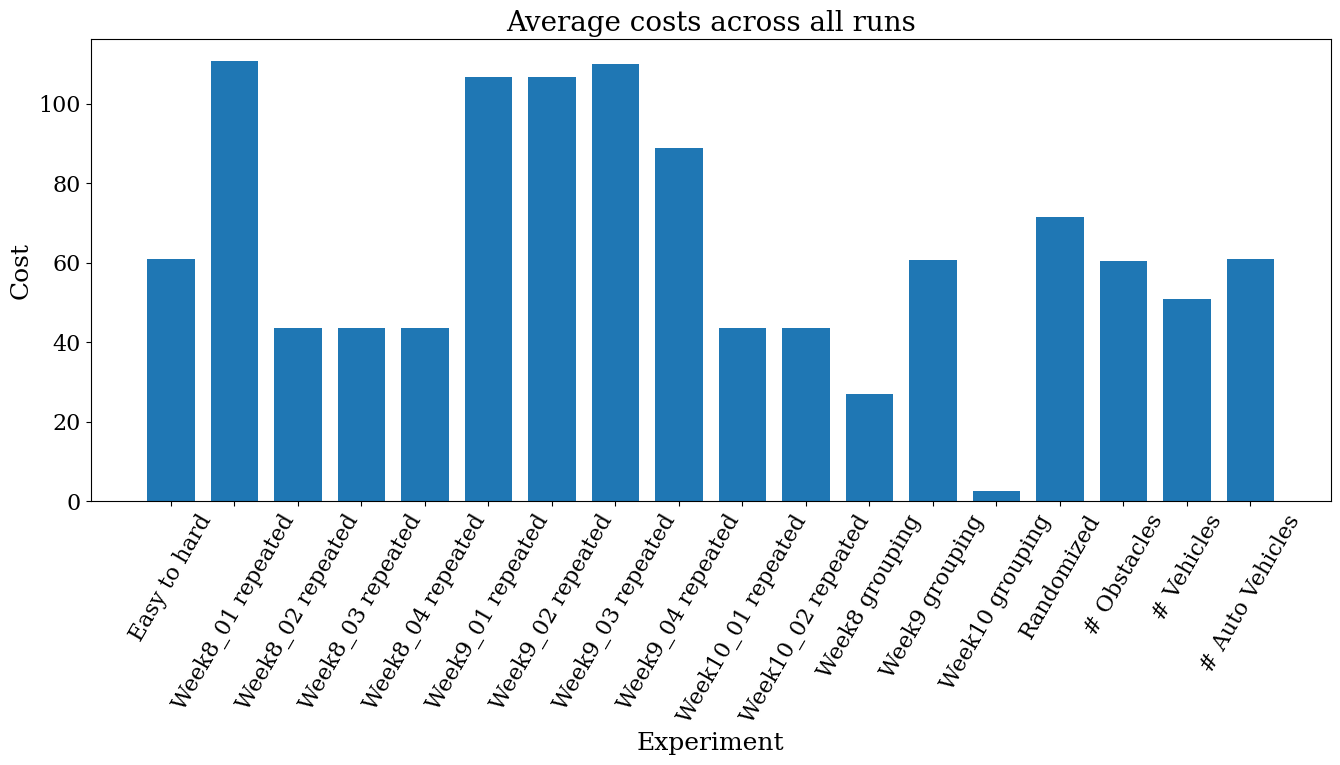

In [42]:
avg_cost_all_df = graph_avgs_across_runs("cost")

In [43]:
avg_cost_all_df

,Experiment grouping,Average cost
0,Easy to hard,60.866256
1,Week8_01 repeated,110.662025
2,Week8_02 repeated,43.485078
3,Week8_03 repeated,43.485078
4,Week8_04 repeated,43.486151
5,Week9_01 repeated,106.740467
6,Week9_02 repeated,106.740463
7,Week9_03 repeated,109.904635
8,Week9_04 repeated,88.763954
9,Week10_01 repeated,43.487566


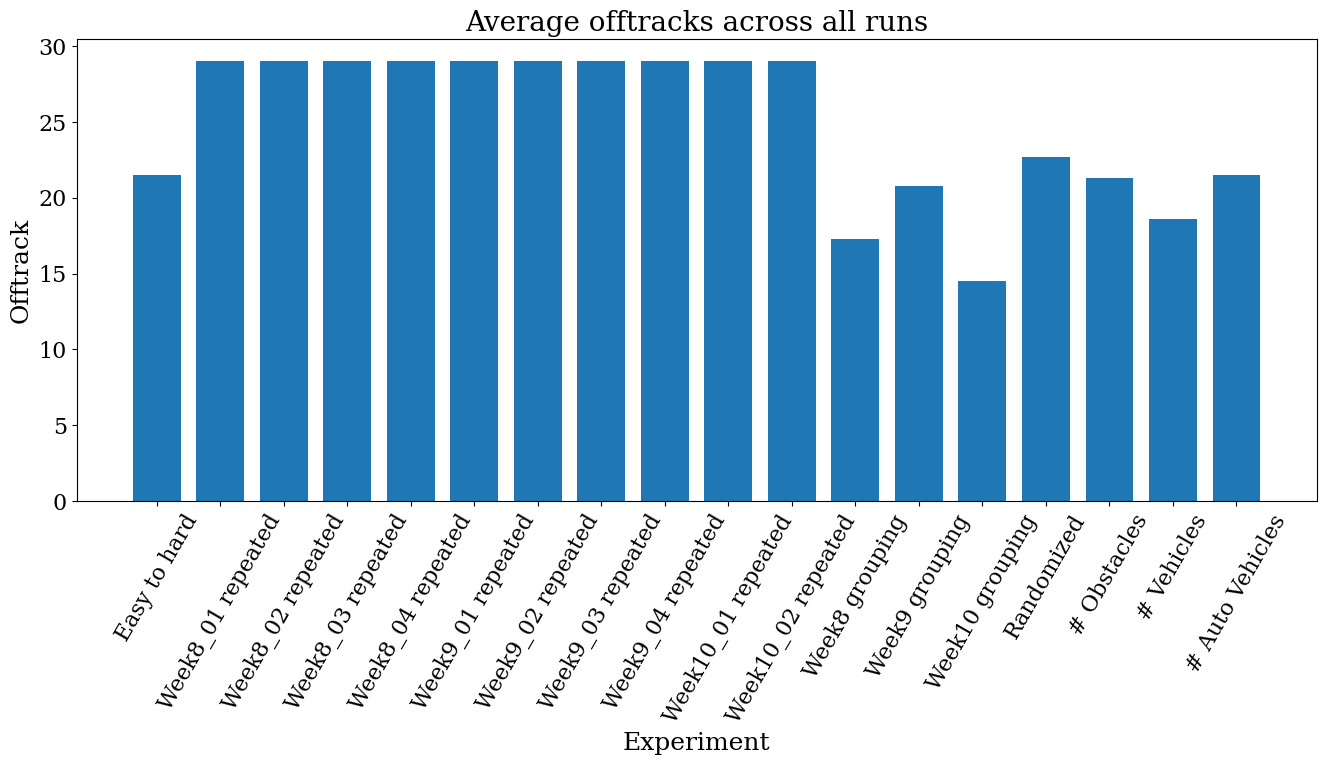

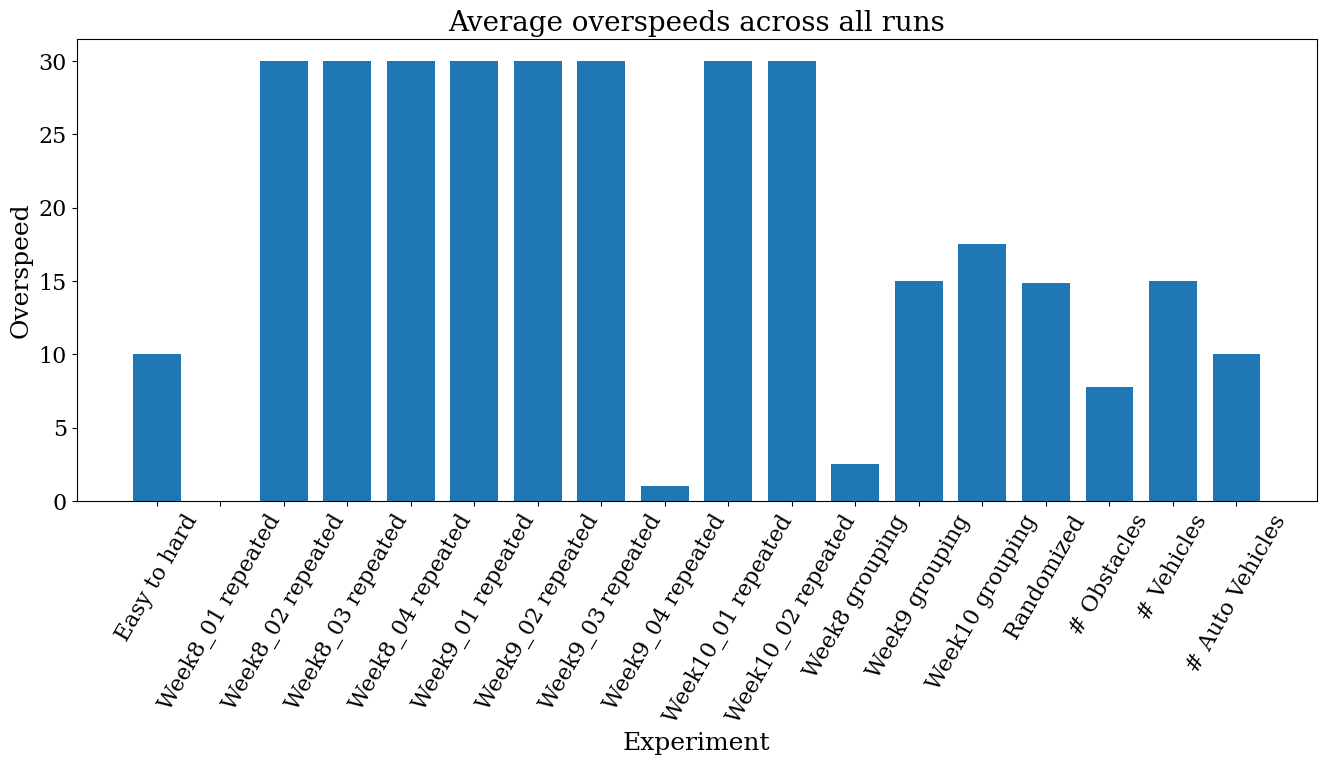

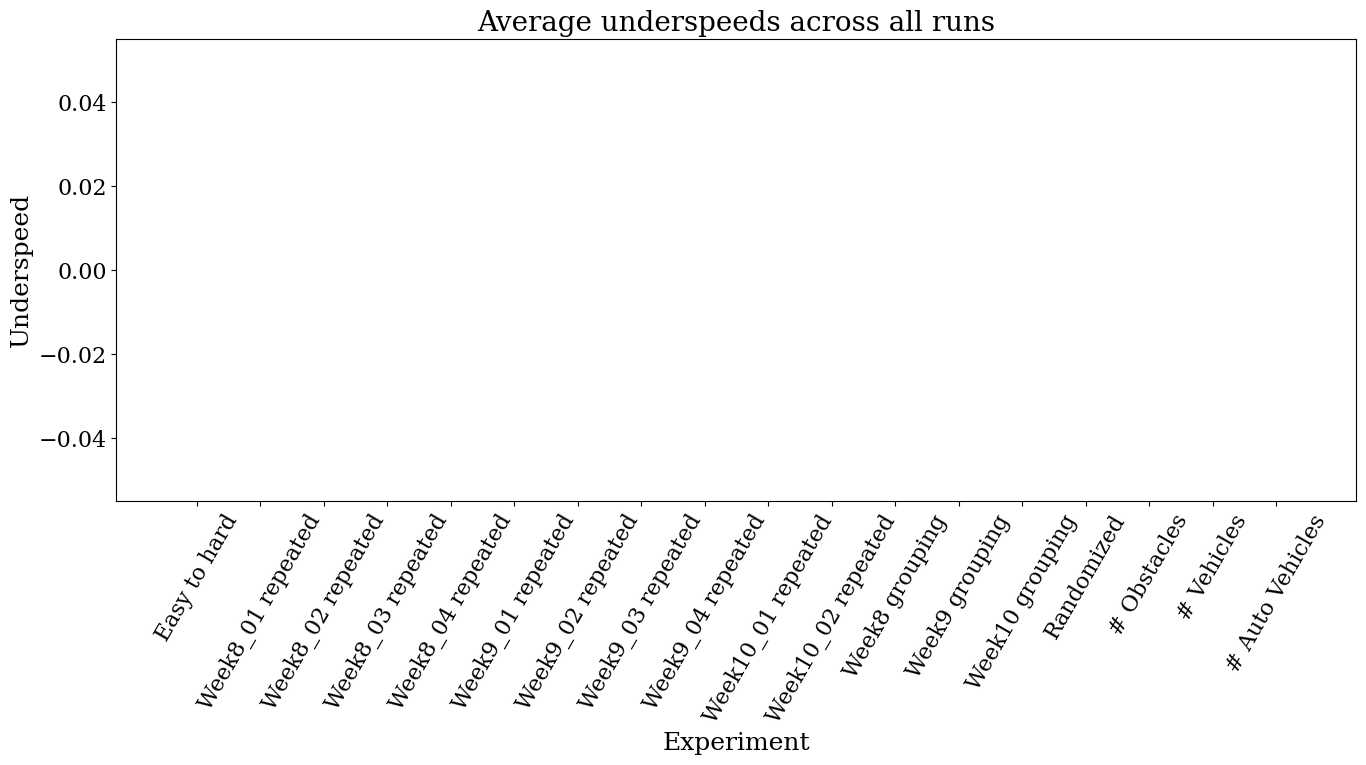

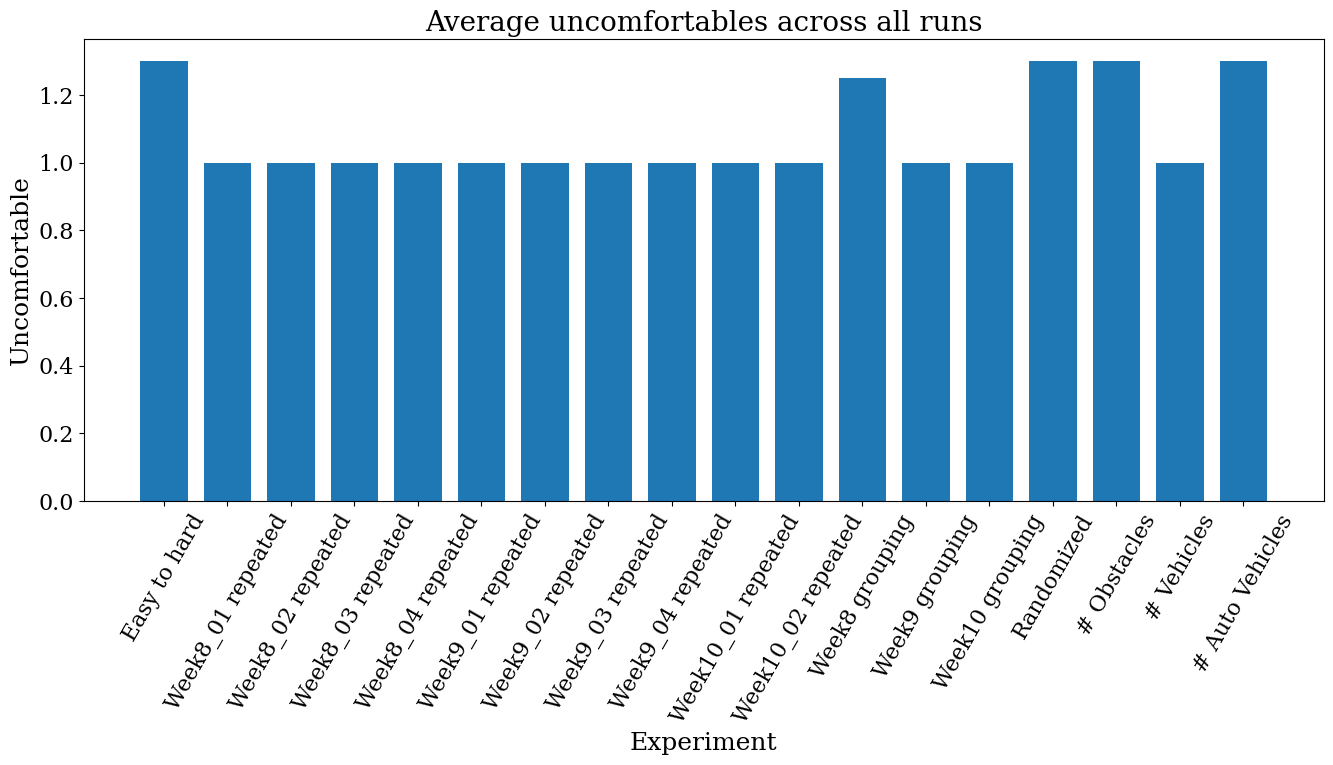

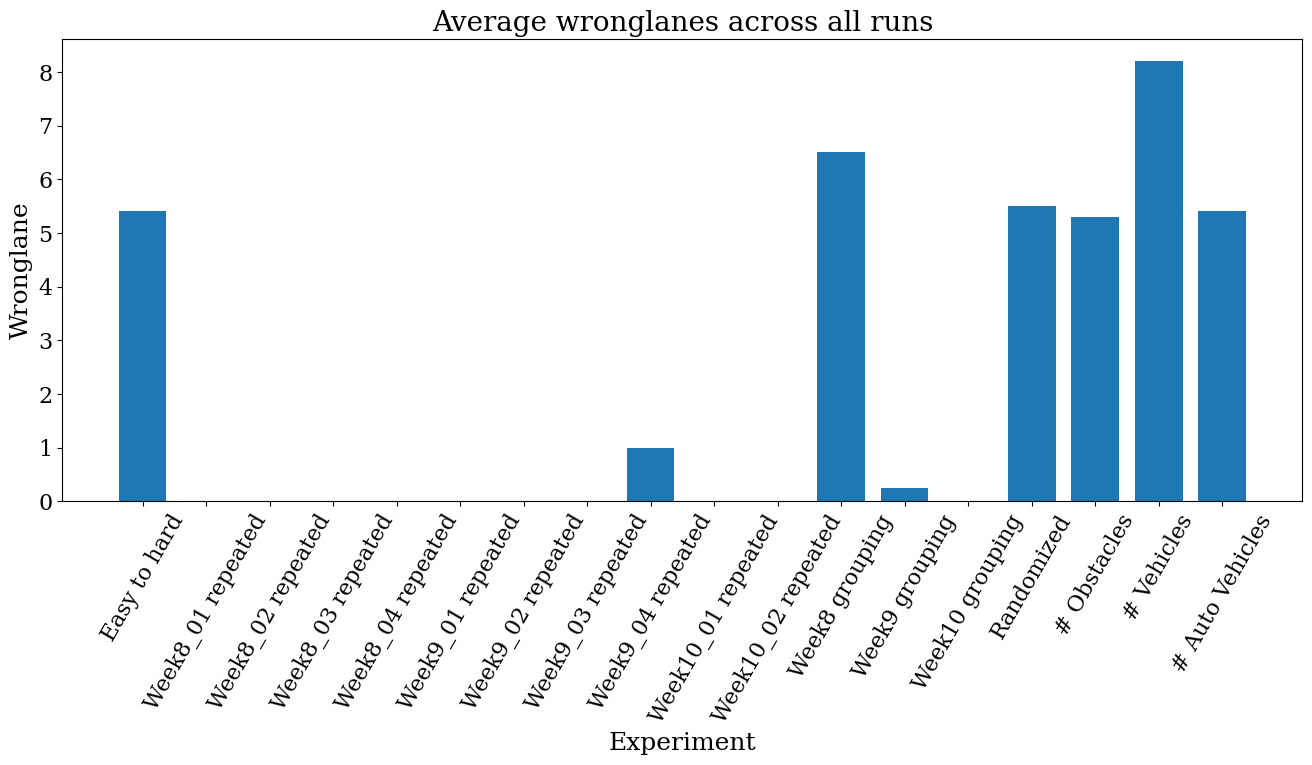

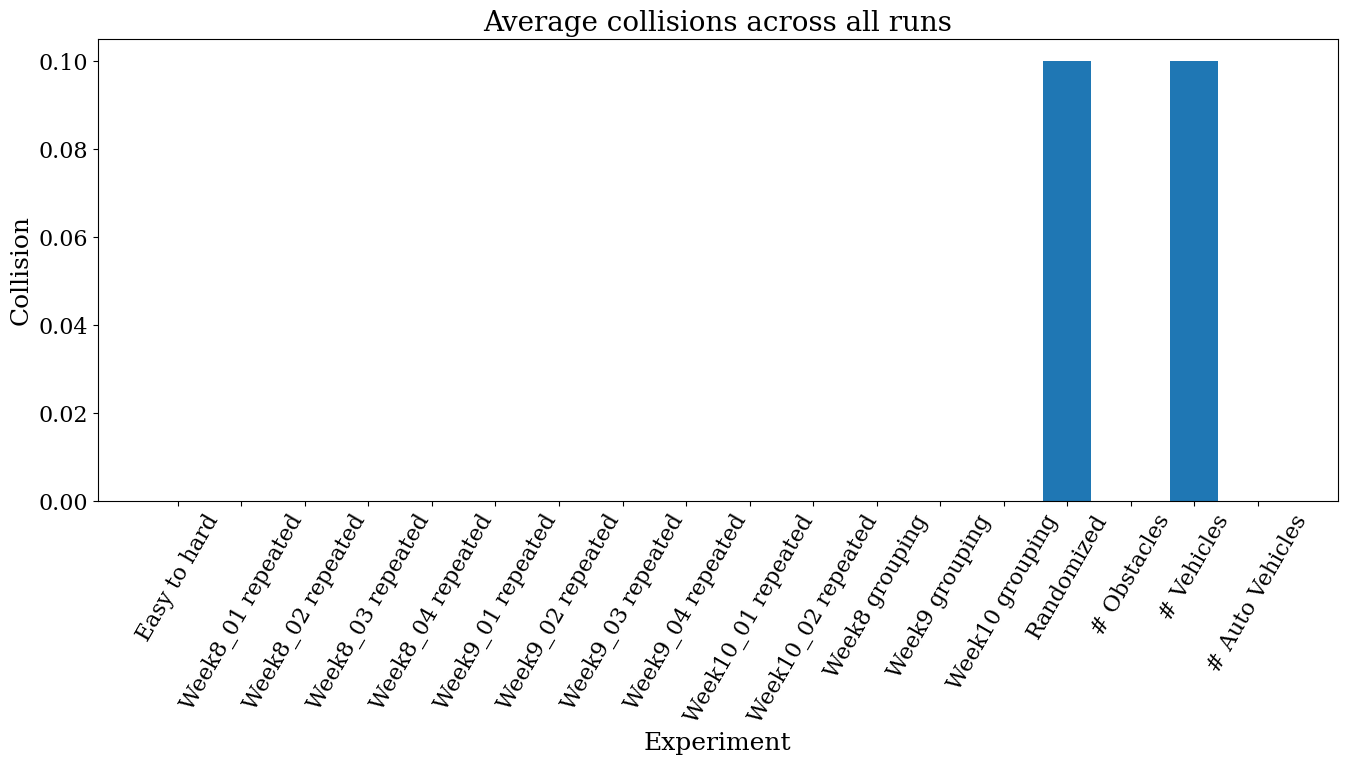

In [44]:
for viol in VIOLATIONS:
    graph_avgs_across_runs(viol)

In [45]:
def graph_viols_across_runs():
    run_1 = list(output_1_dict_avgs.keys())
    run_1 = ['Easy to hard'] + [i + ' repeated' for i in run_1[1:]]

    run_2 = list(output_2_dict_avgs.keys())
    run_2 = [i + ' grouping' for i in run_2[:len(run_2) - 1]] + ['Randomized']

    run_3 = ["# Obstacles", "# Vehicles", "# Auto Vehicles"]

    keys = run_1 + run_2 + run_3

    # Initialize an empty DataFrame
    combined_df = pd.DataFrame({'Experiment grouping': keys})

    for category in VIOLATIONS:
        values = [output_1_dict_avgs[exp][category] if category in output_1_dict_avgs[exp] else 0 for exp in list(output_1_dict_avgs.keys())]
        values += [output_2_dict_avgs[exp][category] if category in output_2_dict_avgs[exp] else 0 for exp in list(output_2_dict_avgs.keys())]
        values += [output_3_dict_avgs[exp][category] if category in output_3_dict_avgs[exp] else 0 for exp in list(output_3_dict_avgs.keys())]

        combined_df[category] = values

    combined_df.set_index('Experiment grouping')

    ax = combined_df.plot(x='Experiment grouping', kind='bar', stacked=True, figsize=(16, 6))

    plt.xlabel('Category', fontsize=18)
    plt.xticks(rotation=60, fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylabel('Violations count', fontsize=18)
    plt.title(f"Average violations across all runs", fontsize=20)
    
    ax.legend(title='Violation type', title_fontsize=16, prop={'size': 16}, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.savefig(f'graphs/Average_violations_all.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()

    # want this in the output df but not the graph
    combined_df['total'] = combined_df.iloc[:, 1:].sum(axis=1)

    return combined_df

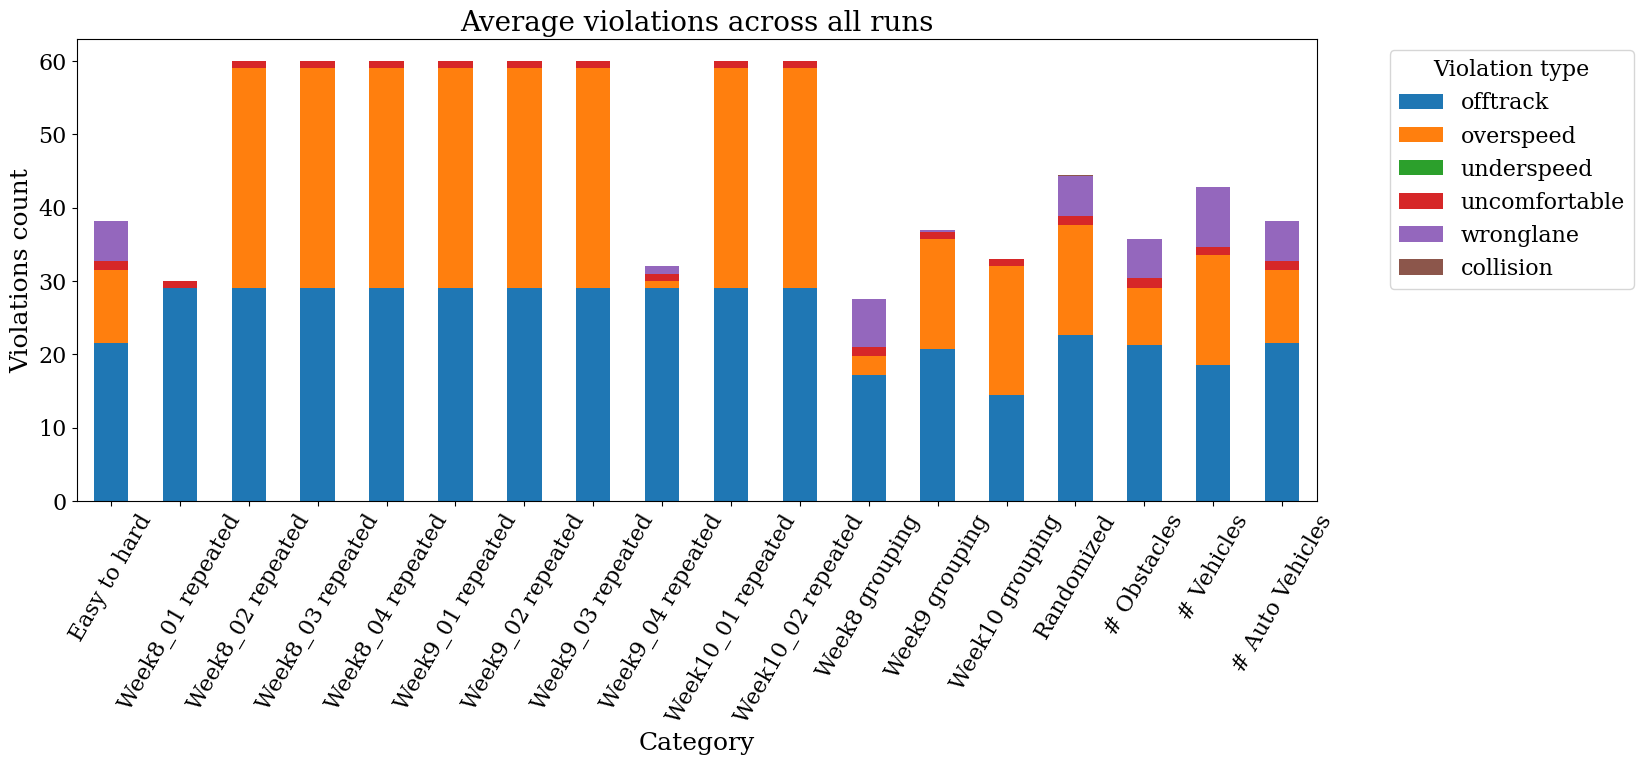

In [46]:
combined_viols_df = graph_viols_across_runs()

In [47]:
combined_viols_df

,Experiment grouping,offtrack,overspeed,underspeed,uncomfortable,wronglane,collision,total
0,Easy to hard,21.50,10.0,0.0,1.30,5.40,0.0,38.2
1,Week8_01 repeated,29.00,0.0,0.0,1.00,0.00,0.0,30.0
2,Week8_02 repeated,29.00,30.0,0.0,1.00,0.00,0.0,60.0
3,Week8_03 repeated,29.00,30.0,0.0,1.00,0.00,0.0,60.0
4,Week8_04 repeated,29.00,30.0,0.0,1.00,0.00,0.0,60.0
5,Week9_01 repeated,29.00,30.0,0.0,1.00,0.00,0.0,60.0
6,Week9_02 repeated,29.00,30.0,0.0,1.00,0.00,0.0,60.0
7,Week9_03 repeated,29.00,30.0,0.0,1.00,0.00,0.0,60.0
8,Week9_04 repeated,29.00,1.0,0.0,1.00,1.00,0.0,32.0
9,Week10_01 repeated,29.00,30.0,0.0,1.00,0.00,0.0,60.0


In [48]:
def graph_avgs(data, title, category):
    weeks = list(data.keys())
    
    values = [data[week][category] if category in data[week] else 0 for week in weeks]
    
    plt.bar([w.title() for w in weeks], values, label=category)
    
    plt.xlabel('Experiment')
    plt.xticks(rotation=45)
    plt.ylabel(category.title())
    plt.title(title)

    plt.savefig(f'graphs/{title}.pdf', format='pdf')
    
    plt.show()

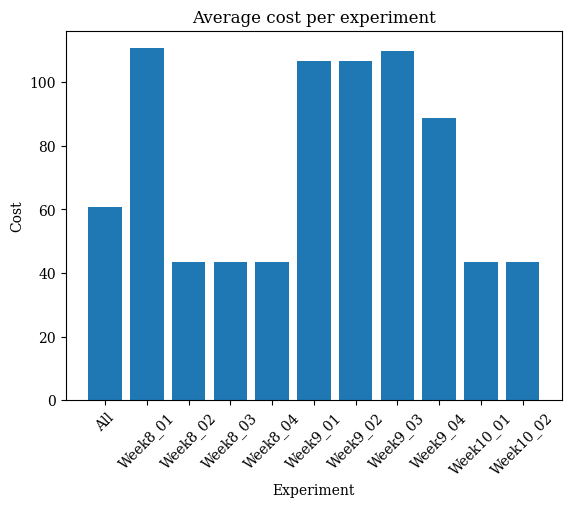

In [49]:
graph_avgs(output_1_dict_avgs, 'Average cost per experiment', 'cost')

In [50]:
pd.DataFrame(output_1_dict_avgs)

,all,Week8_01,Week8_02,Week8_03,Week8_04,Week9_01,Week9_02,Week9_03,Week9_04,Week10_01,Week10_02
cost,60.866256,110.662025,43.485078,43.485078,43.486151,106.740467,106.740463,109.904635,88.763954,43.487566,43.486616
offtrack,21.500000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
overspeed,10.000000,0.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,1.000000,30.000000,30.000000
underspeed,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
uncomfortable,1.300000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
wronglane,5.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
collision,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.000000


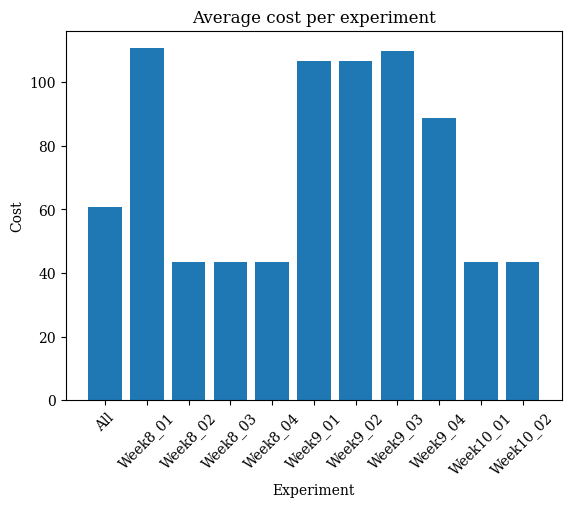

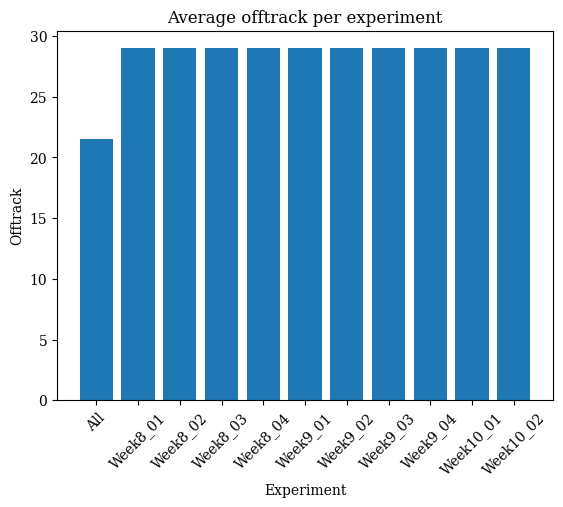

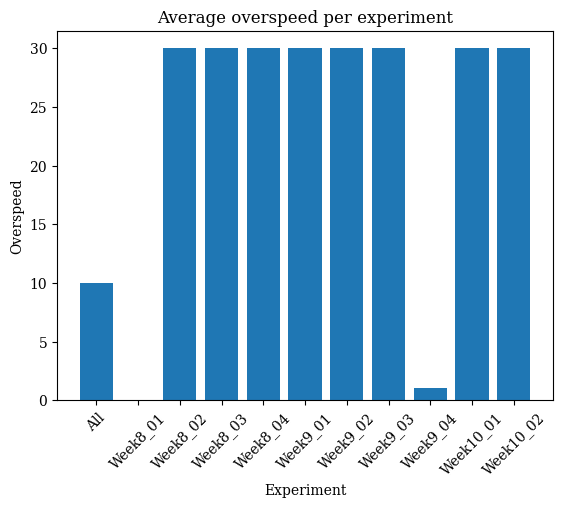

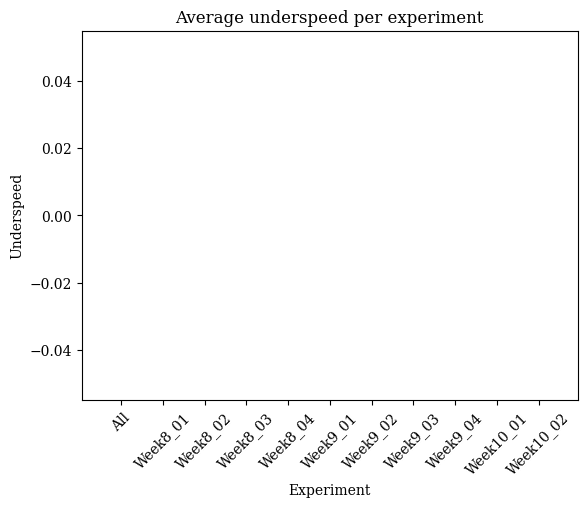

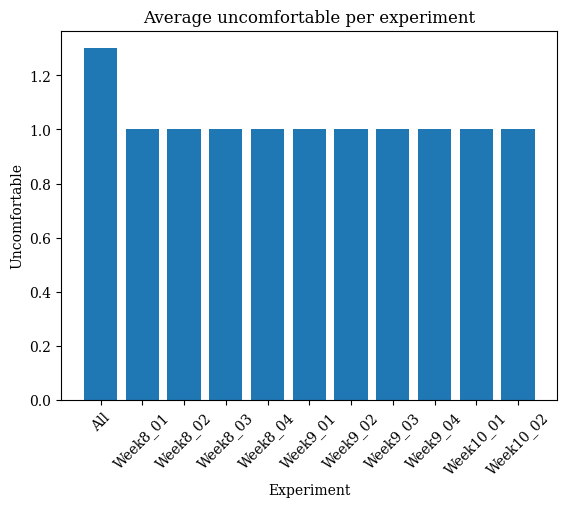

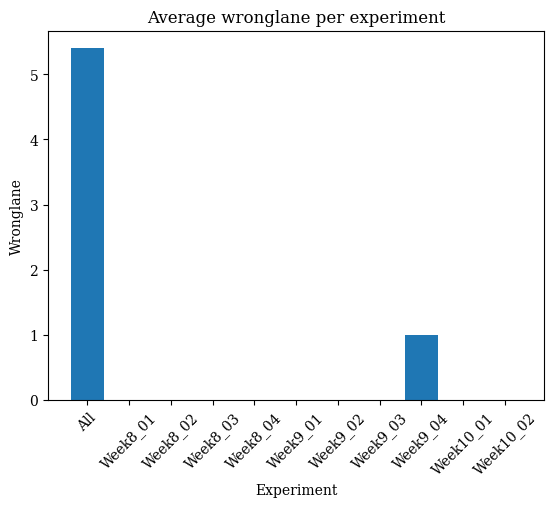

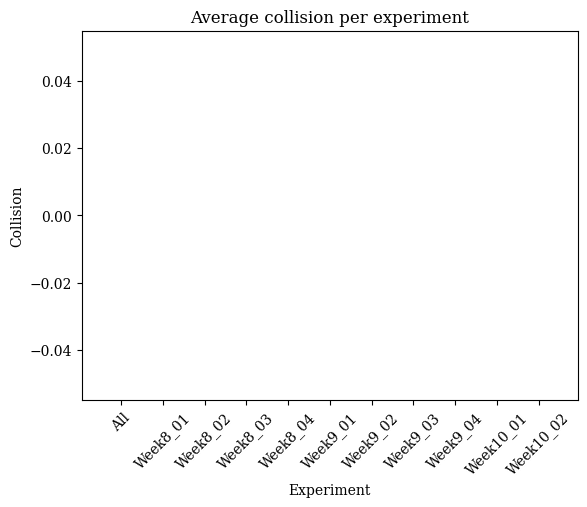

In [51]:
categories = list(output_1_dict['all'].keys())
for c in categories:
    graph_avgs(output_1_dict_avgs, f'Average {c} per experiment', c)

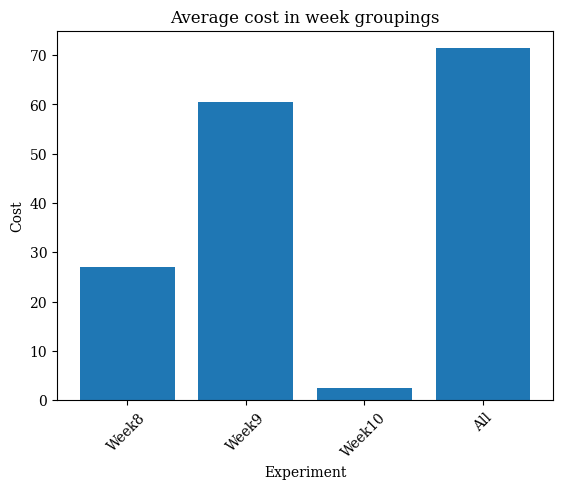

In [52]:
graph_avgs(output_2_dict_avgs, f'Average cost in week groupings', 'cost')

In [53]:
pd.DataFrame(output_2_dict_avgs)

,Week8,Week9,Week10,all
cost,27.023706,60.55227,2.440784,71.377737
offtrack,17.250000,20.75000,14.500000,22.700000
overspeed,2.500000,15.00000,17.500000,14.900000
underspeed,0.000000,0.00000,0.000000,0.000000
uncomfortable,1.250000,1.00000,1.000000,1.300000
wronglane,6.500000,0.25000,0.000000,5.500000
collision,0.000000,NaN,0.000000,0.100000


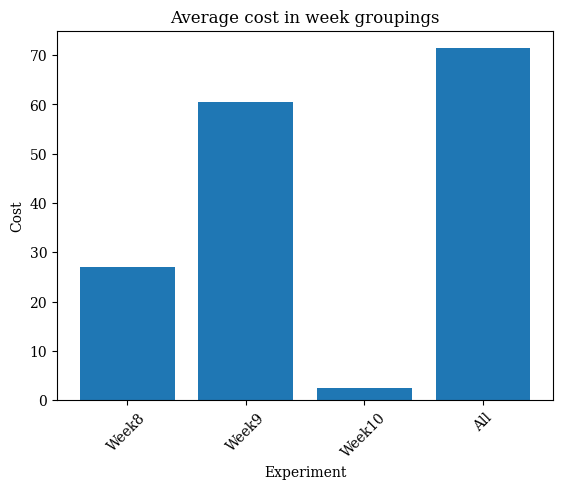

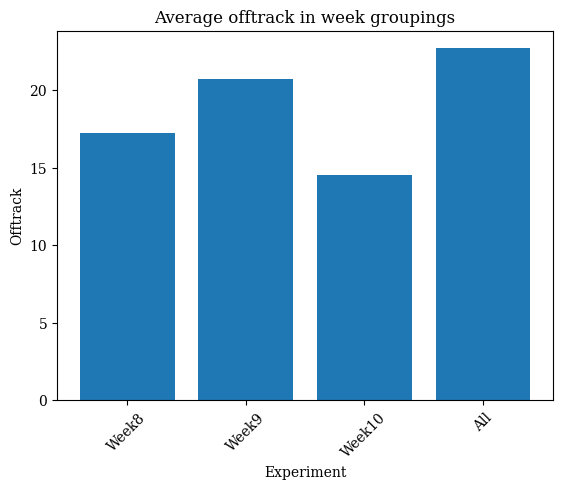

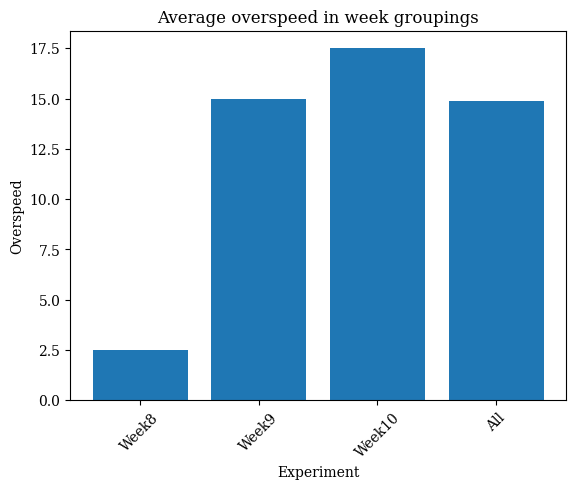

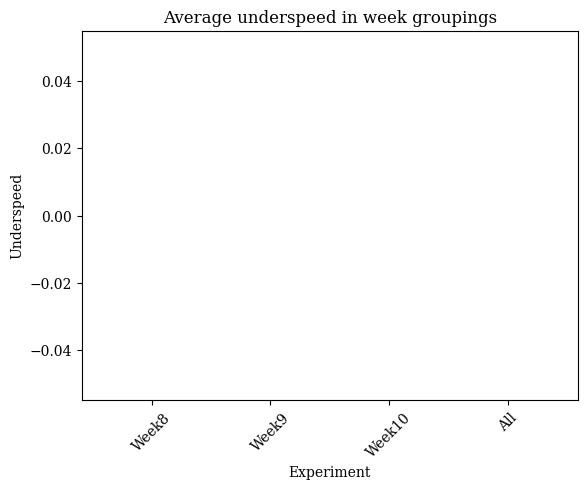

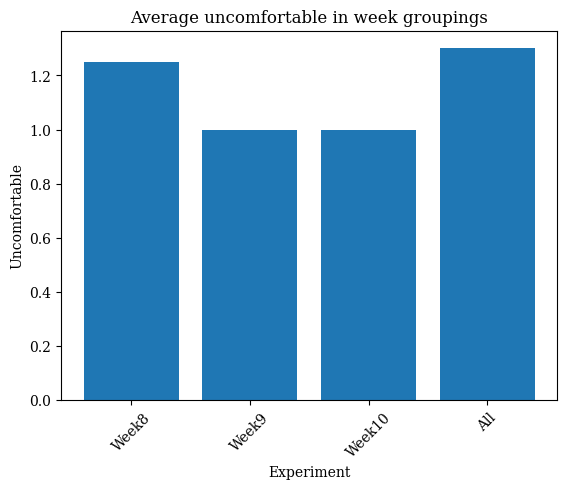

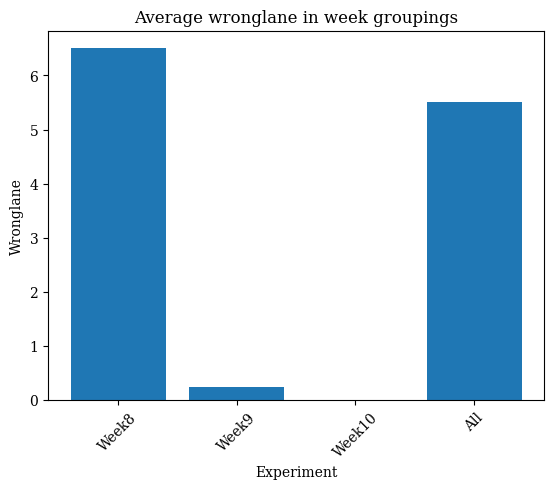

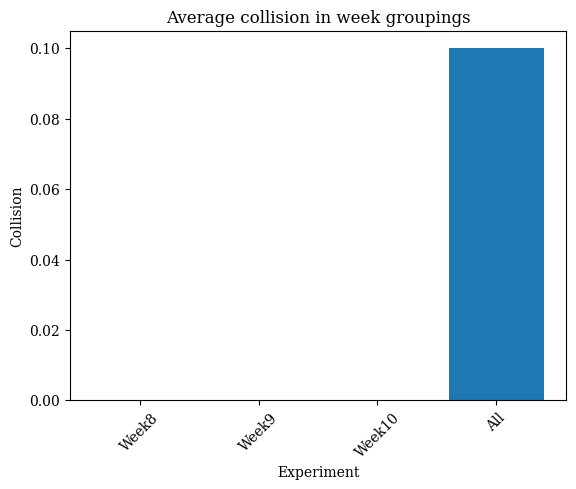

In [54]:
categories = list(output_2_dict['all'].keys())
for c in categories:
    graph_avgs(output_2_dict_avgs, f'Average {c} in week groupings', c)

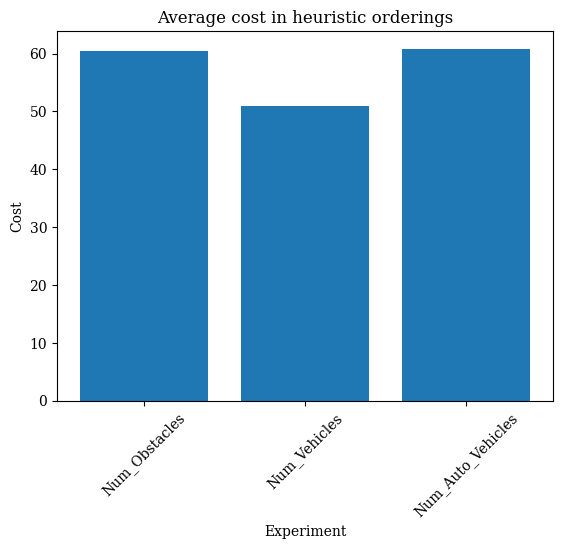

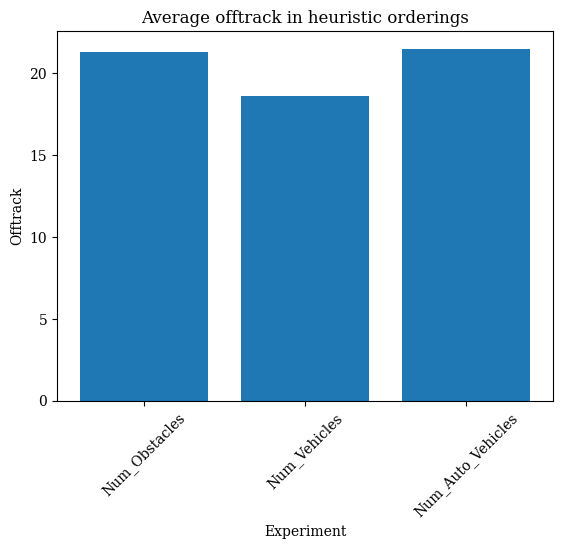

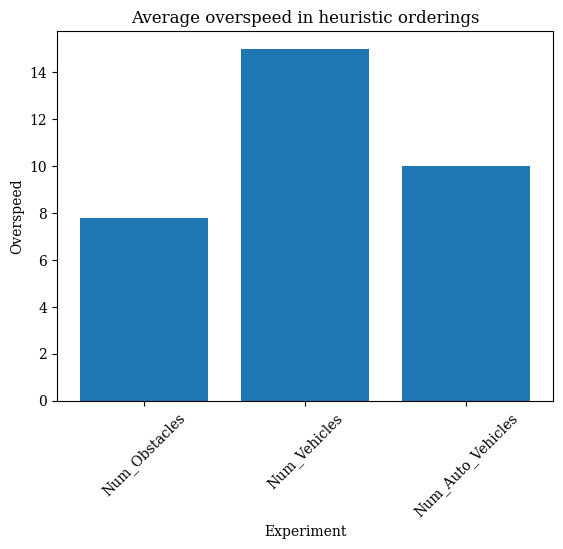

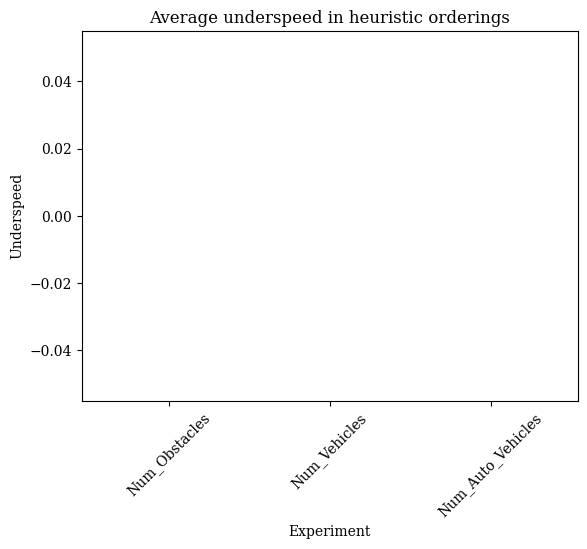

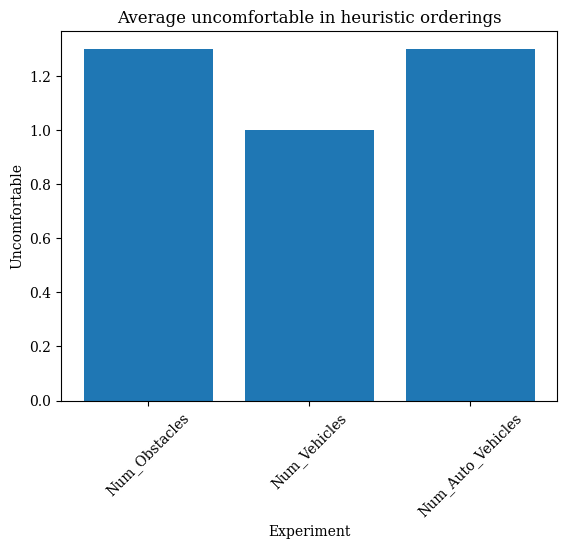

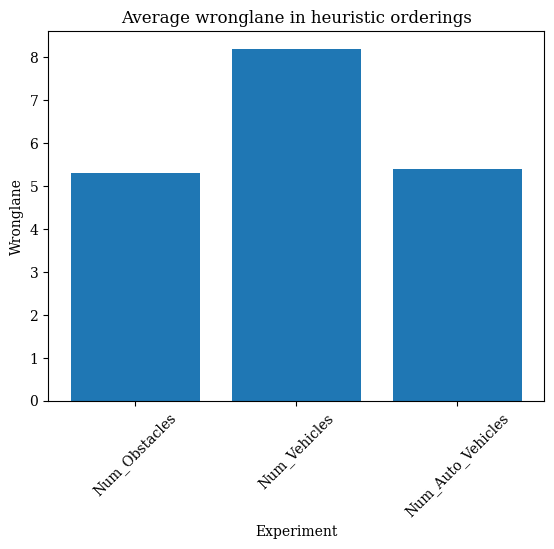

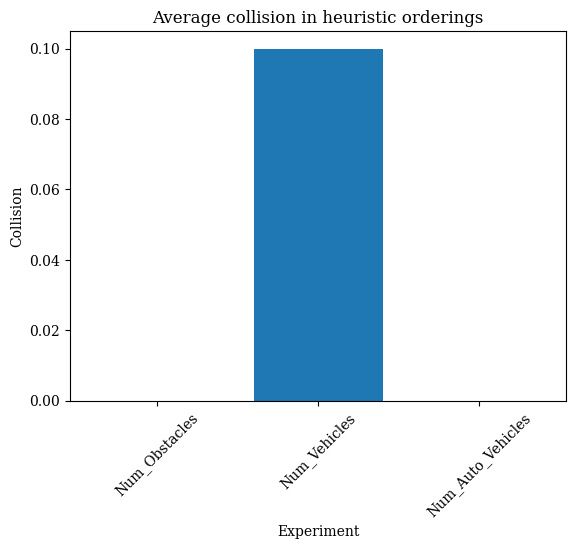

In [55]:
categories = list(output_3_dict['num_obstacles'].keys())
for c in categories:
    graph_avgs(output_3_dict_avgs, f'Average {c} in heuristic orderings', c)

In [56]:
pd.DataFrame(output_3_dict_avgs)

,num_obstacles,num_vehicles,num_auto_vehicles
cost,60.438994,50.917776,60.866256
offtrack,21.300000,18.600000,21.500000
overspeed,7.800000,15.000000,10.000000
underspeed,0.000000,0.000000,0.000000
uncomfortable,1.300000,1.000000,1.300000
wronglane,5.300000,8.200000,5.400000
collision,0.000000,0.100000,0.000000


The prompt inputted into Llama uses the average calculations from `output_1_dict_avgs`'s `costs` field.

_You are training an autonomous vehicle in a series of ten environments to minimize the costs resulting from violations, such as going offtrack or overspeeding. In a series of ten environments, the weights learned from training in the first environment are used as the basis for starting training in the second environment, and so on. The environments are named Week8_01, Week8_02, Week8_03, Week8_04, Week9_01, Week9_02, Week9_03, Week9_03, Week9_04, Week10_01, and Week10_02. \nThe cost of running experiments on all ten environments in alphabetical and numerical order is 60.87. The cost on running an experiment on the same environment ten times is 110.66 for Week8_01, 43.49 for Week8_02, 43.49 for Week8_03, 43.49 for Week8_04, 106.74 for Week9_01, 106.74 for Week9_02, 109.90 for Week9_03, 88.76 for Week9_04, 43.49 for Week10_01, and 43.49 for Week10_02.\nGive an ordering of ten environments as a Python list to minimize the total cost. You can train on any combination of the ten environments, including using an environment multiple times or not at all._

The second generated prompt inputs costs from the previous prompt, but now with heuristic orderings:

_You are training an autonomous vehicle in a series of ten environments to minimize the costs resulting from violations, such as going offtrack or overspeeding. In a series of ten environments, the weights learned from training in the one environment are used as the basis for starting training in the following environment. The environments are named Week8_01, Week8_02, Week8_03, Week8_04, Week9_01, Week9_02, Week9_03, Week9_03, Week9_04, Week10_01, and Week10_02.
 You are given the costs of ordering the environments by heuristics including number of obstacles (cost of -144.94), number of vehicles (cost of 45.61), and number of other autonomous vehicles (cost of -144.94).
The cost of running experiments on all ten environments in alphabetical and numerical order is 60.87. The cost on running an experiment on the same environment ten times is 110.66 for Week8_01, 43.49 for Week8_02, 43.49 for Week8_03, 43.49 for Week8_04, 106.74 for Week9_01, 106.74 for Week9_02, 109.90 for Week9_03, 88.76 for Week9_04, 43.49 for Week10_01, and 43.49 for Week10_02. The features of each environment are given below:
Week8_01 has num_obstacles = 0, num_vehicles = 2, num_auto_vehicles = 0
Week8_02 has num_obstacles = 0, num_vehicles = 1, num_auto_vehicles = 0
Week8_03 has num_obstacles = 0, num_vehicles = 1, num_auto_vehicles = 0
Week8_04 has num_obstacles = 0, num_vehicles = 3, num_auto_vehicles = 0
Week9_01 has num_obstacles = 1, num_vehicles = 0, num_auto_vehicles = 0
Week9_02 has num_obstacles = 1, num_vehicles = 0, num_auto_vehicles = 0
Week9_03 has num_obstacles = 1, num_vehicles = 0, num_auto_vehicles = 0
Week9_04 has num_obstacles = 2, num_vehicles = 0, num_auto_vehicles = 0
Week10_01 has num_obstacles = 0, num_vehicles = 0, num_auto_vehicles = 1
Week10_02 has num_obstacles = 0, num_vehicles = 1, num_auto_vehicles = 1
Give an ordering of ten environments as a Python list to minimize the total cost. You can train on any combination of the ten environments, including using an environment multiple times or not at all. Note that environment ordering does matter since weights are transfered sequentially._
